# Applying a simple Davies+16 smoothness condition

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import theano.tensor as tt
import lightkurve as lk
from astropy.units import cds
from astropy import units as u
import seaborn as sns
import mystyle as ms

import corner
import pystan
import pandas as pd
import pickle
import glob
from astropy.io import ascii
import os

from utils import *

import pymc3 as pm
import arviz

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
target = 3632418
f, p, ff, pp, star, modelocs, elocs, modeids, overtones = read_data(target, 12, 36)

In [3]:
bins_ = 20
# f, p = rebin(f, p, bins_)

In [4]:
kic = star.KIC

In [5]:
backdir = glob.glob('/home/oliver/PhD/mnt/RDS/malatium/backfit/'
                +str(kic)+'/*_fit.pkl')[0]
with open(backdir, 'rb') as file:
    backfit = pickle.load(file)

labels=['loga','logb','logc','logd','logj','logk','white','scale','nyq']
res = np.array([np.median(backfit[label]) for label in labels])
res[0:6] = 10**res[0:6]

phi_ = np.array([np.median(backfit[label]) for label in labels])
phi_sigma = pd.DataFrame(backfit)[labels].cov()
phi_cholesky = np.linalg.cholesky(phi_sigma)

mm = get_background(ff, *res)
m = get_background(f, *res)
p /= m
pp /= mm

## Build the model

In [6]:
class model():
    def __init__(self, f, n0_, n1_, n2_):
        self.f = f
        self.n0 = n0_
        self.n1 = n1_
        self.n2 = n2_
        self.npts = len(f)
        self.M = [len(n0_), len(n1_), len(n2_)]
        
    def epsilon(self, i, theano=True):
        eps = tt.zeros((3,3))
        eps0 = tt.set_subtensor(eps[0][0], 1.)
        eps1 = tt.set_subtensor(eps[1][0], tt.cos(i)**2)
        eps1 = tt.set_subtensor(eps1[1], 0.5 * tt.sin(i)**2)
        eps2 = tt.set_subtensor(eps[2][0], 0.25 * (3. * tt.cos(i)**2 - 1.)**2)
        eps2 = tt.set_subtensor(eps2[1], (3./8.)*tt.sin(2*i)**2)
        eps2 = tt.set_subtensor(eps2[2], (3./8.) * tt.sin(i)**4)

        eps = tt.set_subtensor(eps[0], eps0)
        eps = tt.set_subtensor(eps[1], eps1)
        eps = tt.set_subtensor(eps[2], eps2)
        
        if not theano:
            return eps.eval()
        return eps
            

    def lor(self, freq, h, w):
        return h / (1.0 + 4.0/w**2*(self.f - freq)**2)
    
    def mode(self, l, freqs, hs, ws, eps, split=0):
        for idx in range(self.M[l]):
            for m in range(-l, l+1, 1):
                self.modes += self.lor(freqs[idx] + (m*split), 
                                     hs[idx] * eps[l,abs(m)], 
                                     ws[idx])
  
    def model(self, p, theano=True):
        f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, b = p
               
        # Calculate the modes
        eps = self.epsilon(i, theano)        
        self.modes = np.zeros(self.npts)
        self.mode(0, f0, h0, g0, eps)
        self.mode(1, f1, h1, g1, eps, split)
        self.mode(2, f2, h2, g2, eps, split)
               
        #Create the model
        self.mod = self.modes + b
        return self.mod

In [7]:
f0_ = modelocs[modeids==0]
f1_ = modelocs[modeids==1]
f2_ = modelocs[modeids==2]
f0_e = elocs[modeids==0]
f1_e = elocs[modeids==1]
f2_e = elocs[modeids==2]
n0 = overtones[modeids==0]
n1 = overtones[modeids==1]
n2 = overtones[modeids==2]
numax_ = star.numax

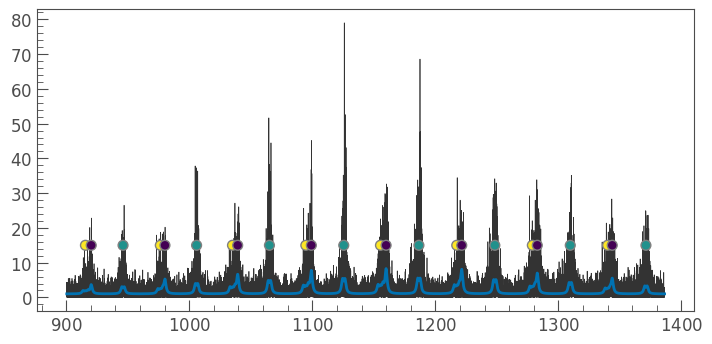

In [8]:
init_m =[f0_,                         # l0 modes
       f1_,                         # l1 modes
       f2_,                         # l2 modes
       np.ones(len(f0_)) * 2.0,     # l0 widths
       np.ones(len(f1_)) * 2.0,     # l1 widths
       np.ones(len(f2_)) * 2.0,     # l2 widths
       np.sqrt(gaussian(f0_, 0, numax_, 15.) * 2.0 * np.pi / 2.0) ,# l0 heights
       np.sqrt(gaussian(f1_, 1, numax_, 15.) * 2.0 * np.pi / 2.0) ,# l1 heights
       np.sqrt(gaussian(f2_, 2, numax_, 15.) * 2.0 * np.pi / 2.0) ,# l2 heights
       1.0,       # splitting
       np.pi/2.,                    # inclination angle
       1.                           # background parameters
        ]

mod = model(f, n0, n1, n2)
with plt.style.context(lk.MPLSTYLE):
    fig, ax = plt.subplots()
    ax.plot(f, p)
    ax.plot(f, mod.model(init_m, theano=False), lw=2)
    ax.scatter(modelocs, [15]*len(modelocs),c=modeids, s=50, edgecolor='grey', zorder=100)
    plt.show()

## The smoothness conditions:

We will use the following as in Davies et al. 2016. The conditions are aimed to include the prior information that the large separation and the small separation are roughly consistent with zero at all radial orders $n$.

For the large separation, we use:

$\ln (p(\theta_l)) = -0.125 \Large\sum^{n_{\rm max}}_{n_{\rm min}}\Large(\frac{\partial^2\nu_{n, l}}{\partial n^2})^2$

where $p(\theta_l)$ is a prior on the parameters $\theta_l$ that apply to the modes of degree $l$. This condition is applied to all sets of modes. The first derivative of the mode locations is the large separation.

For the small separation, we use:

$\ln (p(\theta_l)) = -0.25 \Large\sum^{n_{\rm max}}_{n_{\rm min}}\Large(\frac{\partial\delta\nu_{0,2}(n)}{\partial n})^2$

where we apply this prior on the $\delta\nu_{0,2}$ separations only. Technically, the radial order $n$ of the $l=2$ member of the pair will be $n-1$ compared to $l=0$, but we will treat them as both having the same $n$ as the $l=0$.

In [9]:
def lnplarge(fs):
    
    dnus = np.array([fs[n+1] - fs[n] for n in range(len(f0_)-1)])
    sdif = np.array([dnus[n+1] - dnus[n] for n in range(len(dnus)-1)])
    
    return -0.125 * sum(sdif*sdif)

def lnpsmall(f0s, f2s):
    
    d02s = np.array([f0s[n] - f2s[n] for n in range(len(f0_))])
    
    return -0.25 * sum(d02s*d02s)

In [10]:
pm_model = pm.Model()

with pm_model:
    f0 = pm.Normal('f0', mu=f0_, sigma=.01, testval=f0_, shape=len(f0_))
    f1 = pm.Normal('f1', mu=f1_, sigma=.01, testval=f1_, shape=len(f1_))    
    f2 = pm.Normal('f2', mu=f2_, sigma=.01, testval=f2_, shape=len(f2_))
    
    pm.Deterministic('lnplarge0', lnplarge(f0))
    pm.Deterministic('lnplarge1', lnplarge(f1))
    pm.Deterministic('lnplarge2', lnplarge(f2))
    
    like0 = pm.Potential('like0', lnplarge(f0))
    like1 = pm.Potential('like1', lnplarge(f1))
    like2 = pm.Potential('like2', lnplarge(f2))
    

    pm.Deterministic('lnpsmall', lnpsmall(f0, f2))
    like02 = pm.Potential('like02', lnpsmall(f0, f2))
    
    trace = pm.sample()

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [f2, f1, f0]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:04<00:00, 857.71draws/s] 


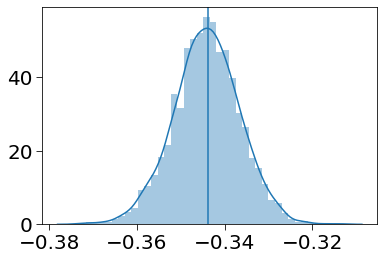

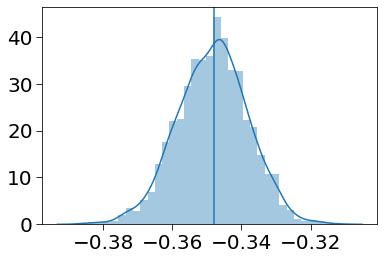

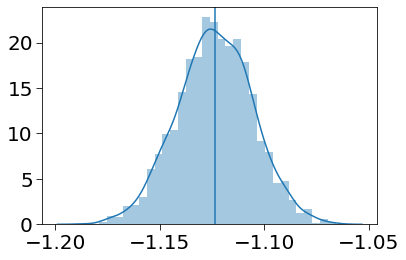

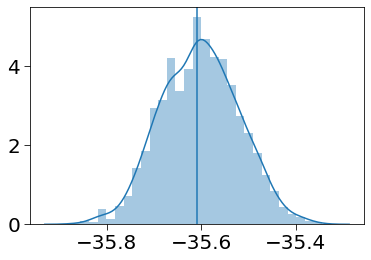

In [11]:
sns.distplot(trace['lnplarge0'])
plt.axvline(lnplarge(f0_))
plt.show()
sns.distplot(trace['lnplarge1'])
plt.axvline(lnplarge(f1_))
plt.show()
sns.distplot(trace['lnplarge2'])
plt.axvline(lnplarge(f2_))
plt.show()
sns.distplot(trace['lnpsmall'])
plt.axvline(lnpsmall(f0_, f2_))

# Now lets apply to apply these priors to our regular peak bagging code

In [14]:
pm_model = pm.Model()

with pm_model:      
    #Frequencies
    f0 = pm.Normal('f0', mu=f0_, sigma=10.*f0_e, testval=f0_, shape=len(f0_))
    f1 = pm.Normal('f1', mu=f1_, sigma=10.*f1_e, testval=f1_, shape=len(f1_))
    f2 = pm.Normal('f2', mu=f2_, sigma=10.*f2_e, testval=f2_, shape=len(f2_))    
    
    # Smoothness conditions
    pm.Deterministic('lnl0', lnplarge(f0))
    pm.Deterministic('lnl1', lnplarge(f1))
    pm.Deterministic('lnl2', lnplarge(f2))
    pm.Deterministic('lns02', lnpsmall(f0, f2))
    
    pm.Potential('like0', lnplarge(f0))
    pm.Potential('like1', lnplarge(f1))
    pm.Potential('like2', lnplarge(f2))
    pm.Potential('like02', lnpsmall(f0, f2))    
    
    # Mode linewidths
    g0 = pm.HalfNormal('g0', sigma=2.0, testval=init_m[3], shape=len(init_m[3]))
    g1 = pm.HalfNormal('g1', sigma=2.0, testval=init_m[4], shape=len(init_m[4]))
    g2 = pm.HalfNormal('g2', sigma=2.0, testval=init_m[5], shape=len(init_m[5]))
    
    # Mode amplitudes
    a0 = pm.HalfNormal('a0', sigma=20., testval=init_m[6], shape=len(init_m[6]))
    a1 = pm.HalfNormal('a1', sigma=20., testval=init_m[7], shape=len(init_m[7]))
    a2 = pm.HalfNormal('a2', sigma=20., testval=init_m[8], shape=len(init_m[8]))
    
    # Mode heights (determined by amplitude and linewidth)
    h0 = pm.Deterministic('h0', 2*a0**2/np.pi/g0)
    h1 = pm.Deterministic('h1', 2*a1**2/np.pi/g1)
    h2 = pm.Deterministic('h2', 2*a2**2/np.pi/g2)
    
    # Rotation and inclination parameterizations
    xsplit = pm.HalfNormal('xsplit', sigma=2.0, testval=init_m[9] * np.sin(init_m[10]))
    cosi = pm.Uniform('cosi', 0., 1., testval=np.cos(init_m[10]))
    
    # Detangled inclination and splitting
    i = pm.Deterministic('i', np.arccos(cosi))
    split = pm.Deterministic('split', xsplit/pm.math.sin(i))
    
    # Background terms
    b = pm.TruncatedNormal('b', mu=1., sigma=.1, lower=0., testval=init_m[11])
    
    #Model
    fit = mod.model([f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, b])
    
    like = pm.Gamma('like', alpha=1., beta=1.0/fit, observed=p)

In [15]:
init = 1000
with pm_model:
    trace = pm.sample(chains=4, tune=int(init/2), draws=int(init/2))

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [b, cosi, xsplit, a2, a1, a0, g2, g1, g0, f2, f1, f0]
Sampling 4 chains: 100%|██████████| 4000/4000 [2:43:01<00:00,  3.11s/draws]  
ERROR:pymc3:There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
INFO:pymc3:The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


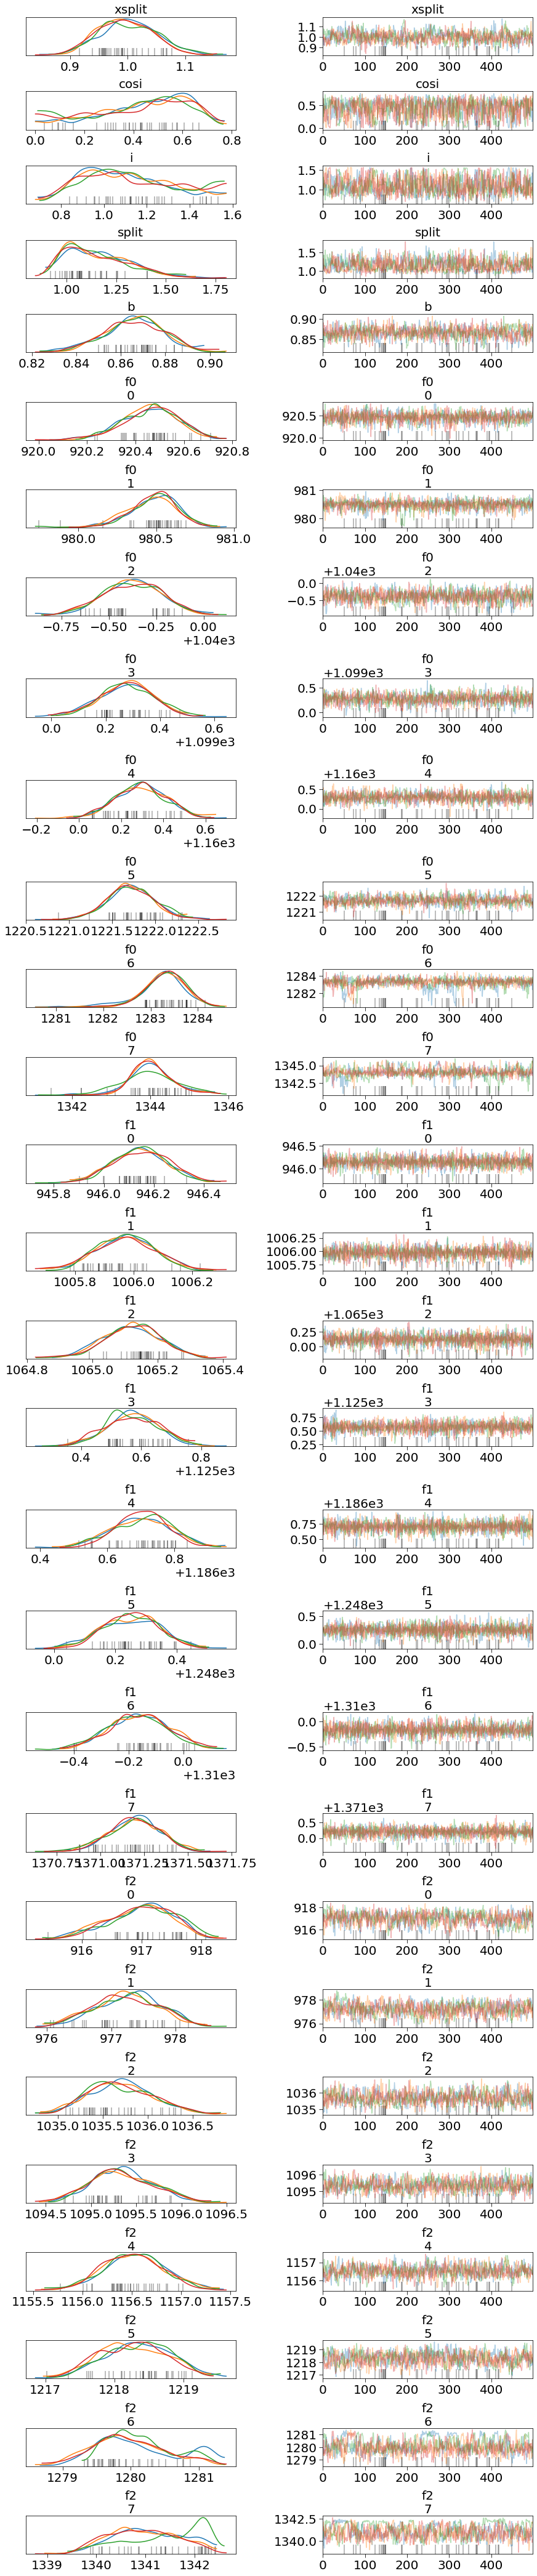

In [16]:
pm.traceplot(trace, var_names=['xsplit','cosi','i','split','b', 'f0', 'f1','f2'])
plt.show()

In [17]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
f0__0,920.460129,0.116372,0.002876,920.229486,920.680309,1512.220201,1.000074
f0__1,980.476139,0.163190,0.005055,980.139766,980.773892,1002.808164,1.001113
f0__2,1039.621106,0.160516,0.004392,1039.303326,1039.931276,960.676732,0.999434
f0__3,1099.275198,0.100402,0.002606,1099.076673,1099.469990,1276.819668,1.001245
f0__4,1160.293682,0.120669,0.002926,1160.055964,1160.515671,1465.086603,0.999989
f0__5,1221.712569,0.272411,0.008026,1221.163151,1222.244257,979.293509,1.001102
f0__6,1283.253994,0.505159,0.024964,1282.266659,1284.213321,337.618199,1.007686
f0__7,1344.018543,0.624564,0.025593,1342.861415,1345.447602,554.175045,1.000726
f1__0,946.145637,0.111028,0.002090,945.940942,946.366957,3029.046384,1.001575
f1__1,1005.970719,0.101093,0.001698,1005.777518,1006.167941,3433.082389,0.999293


# Now lets plot some diagnostics...

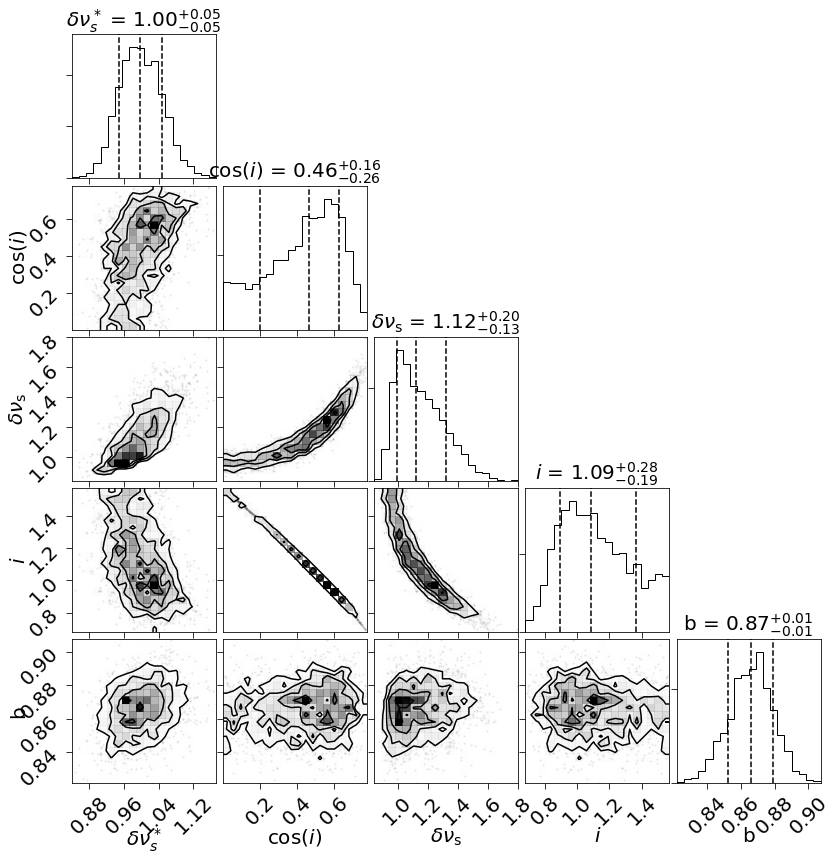

In [18]:
labels=['xsplit','cosi','split','i','b']
truths = [np.nan, np.nan, np.nan, np.nan, 1.]
chain = np.array([trace[label] for label in labels])
verbose = [r'$\delta\nu_s^*$',r'$\cos(i)$',r'$\delta\nu_{\rm s}$', r'$i$','b']
corner.corner(chain.T, labels=verbose, quantiles=[0.16, 0.5, 0.84]
              ,truths=truths, show_titles=True)
plt.show()

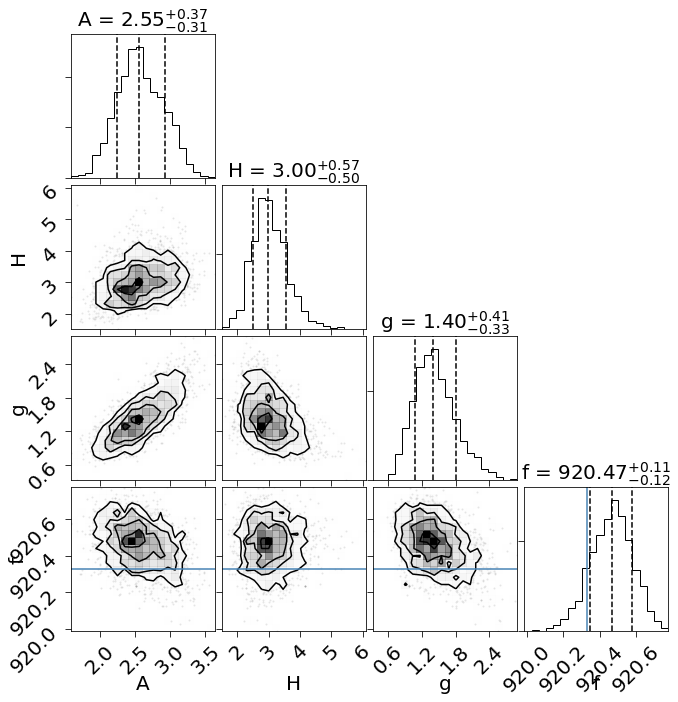

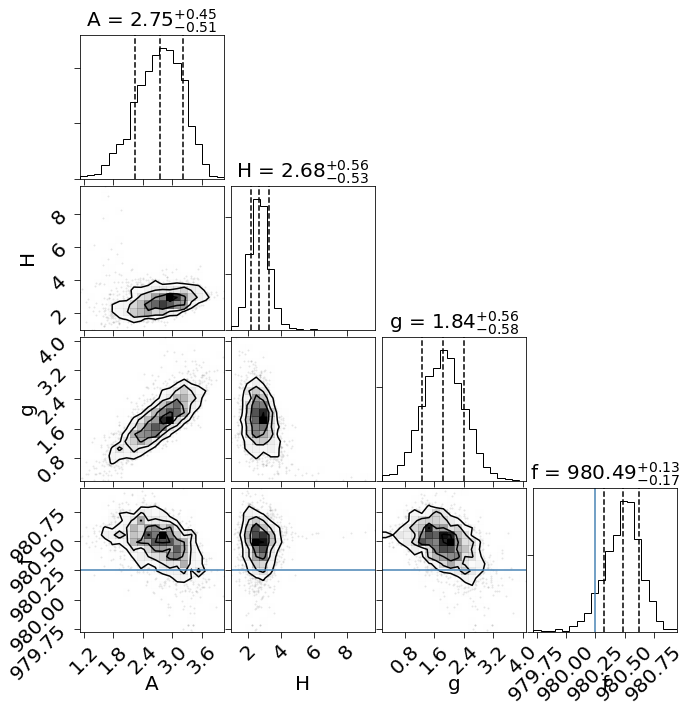

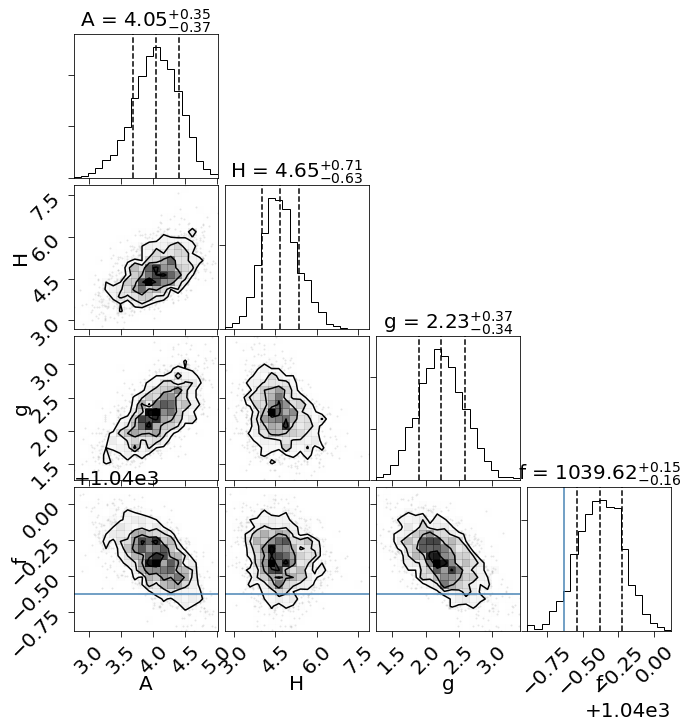

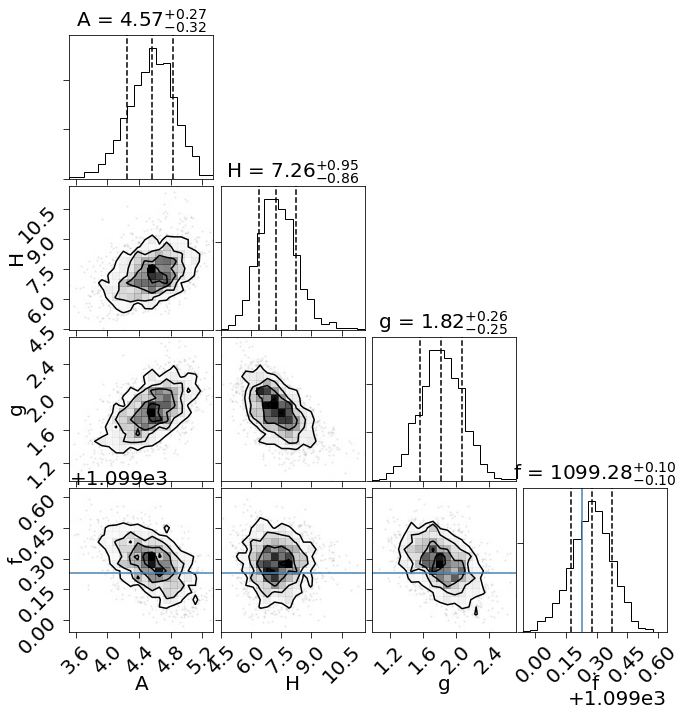

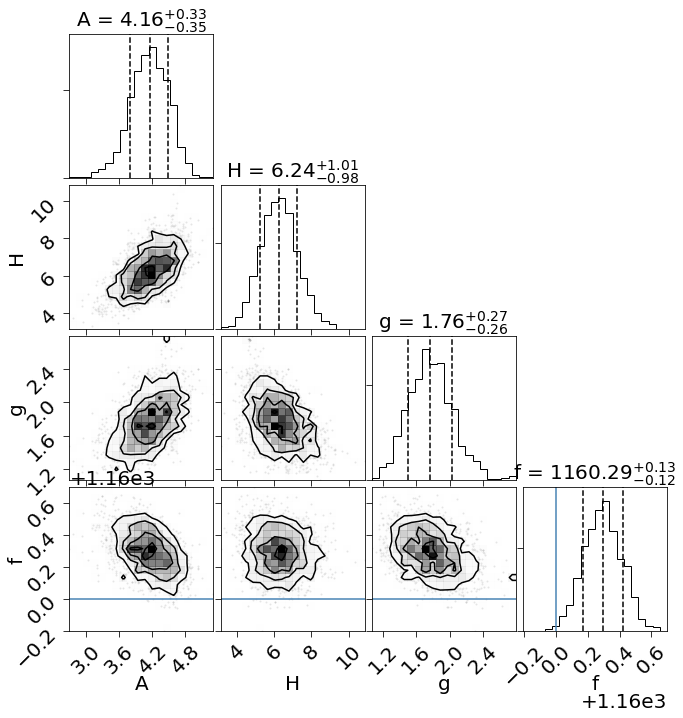

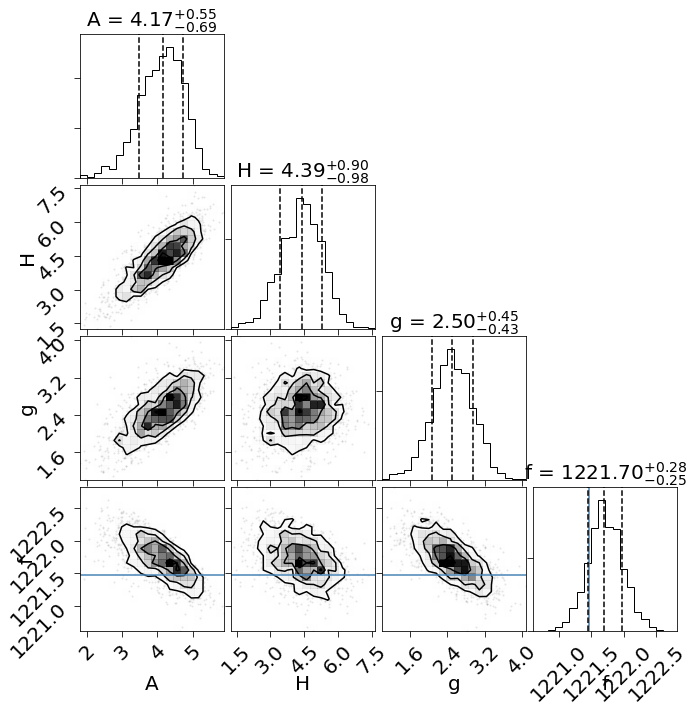

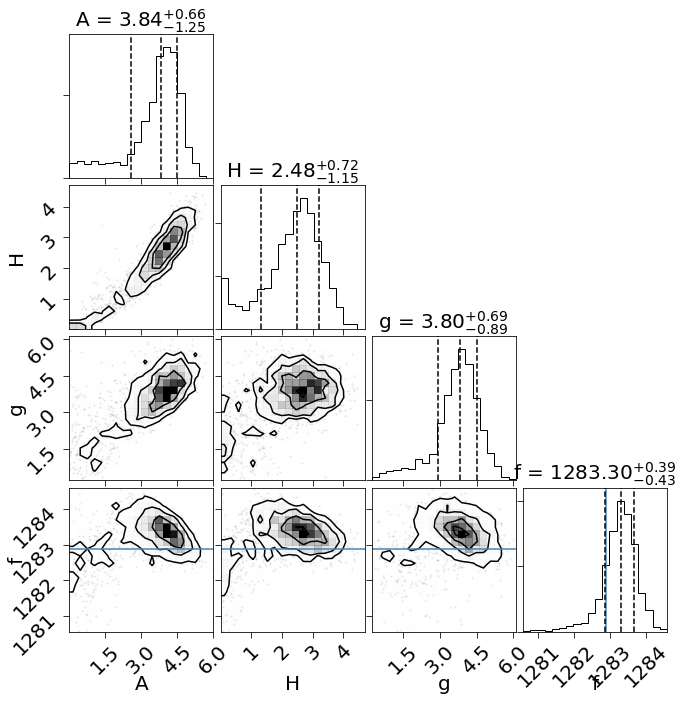

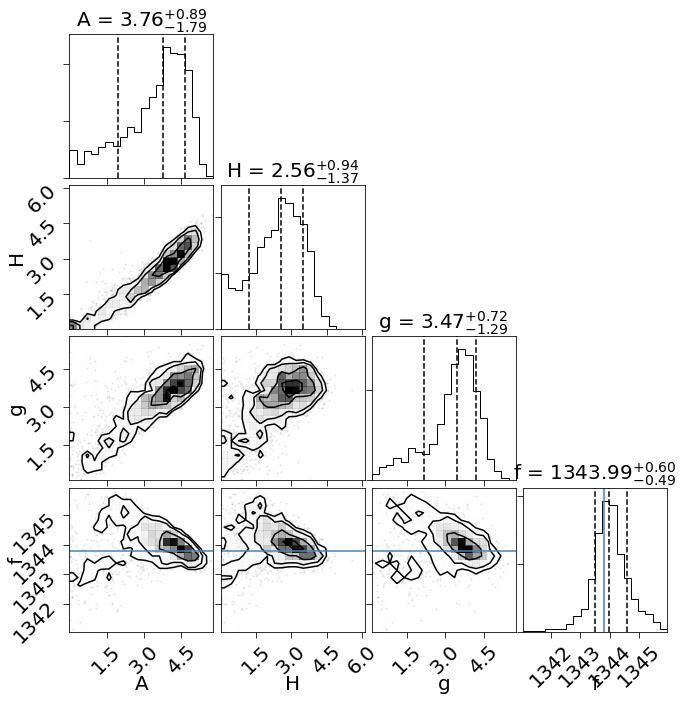

In [19]:
for idx in range(len(trace['h0'].T)):
    truth = [np.nan, np.nan, np.nan, f0_[idx]]
    chain = np.array([trace['a0'].T[idx], trace['h0'].T[idx], trace['g0'].T[idx], trace['f0'].T[idx]])
    corner.corner(chain.T, labels=['A','H','g','f'],truths=truth,
                  quantiles=[0.16, 0.5, 0.84],show_titles=True)
    plt.show()

Looks like all the background parameters have been tightened up or remained within the priors. Always good to check!

### Now let's plot some output evaluation:

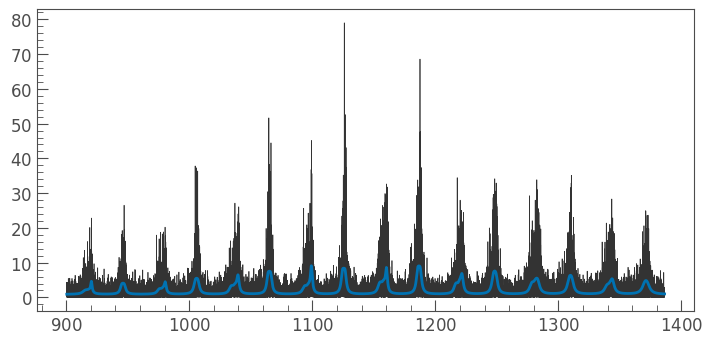

In [20]:
with plt.style.context(lk.MPLSTYLE):
    fig, ax = plt.subplots()
    ax.plot(f, p)
    labels=['f0','f1','f2','g0','g1','g2','h0','h1','h2','split','i', 'b']
    res = np.array([np.median(trace[label],axis=0) for label in labels])    
    ax.plot(f, mod.model(res, theano=False), lw=2)
    plt.show()

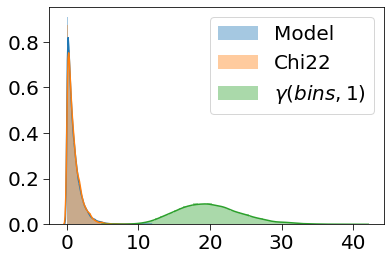

In [21]:
from scipy.stats import gamma
labels=['f0','f1','f2','g0','g1','g2','h0','h1','h2','split','i', 'b']
res = np.array([np.median(trace[label],axis=0) for label in labels])  
residual = p/mod.model(res, theano=False)
sns.distplot(residual, label='Model')
sns.distplot(np.random.chisquare(2, size=10000)/2, label=r'Chi22')
sns.distplot(np.random.gamma(bins_, scale=1, size=10000), label=r'$\gamma(bins, 1)$')
# sns.distplot(np.random.normal(size=10000)*np.std(residual) + np.mean(residual), label='Gaussian')
plt.legend()

# Assessment

Everything is converged but we still have a lot of divergences. Why? Lets dig in.

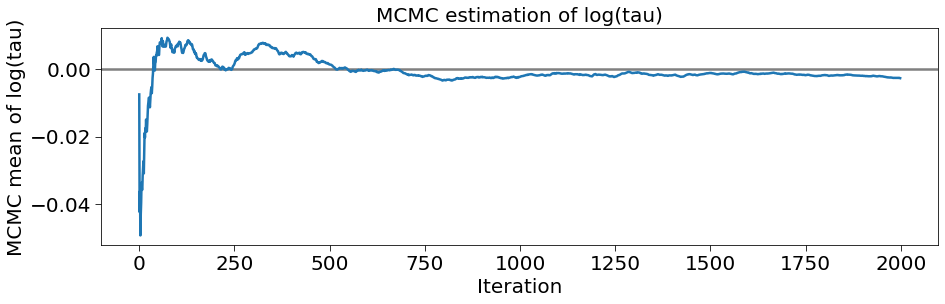

In [23]:
# plot the estimate for the mean of log(τ) cumulating mean
logtau = np.log(trace['xsplit'])
mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]
plt.figure(figsize=(15, 4))
plt.axhline(0., lw=2.5, color='gray')
plt.plot(mlogtau, lw=2.5)
plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(tau)')
plt.title('MCMC estimation of log(tau)');

There seems to be no bias here. So why all the divergence complaints?

In [125]:
def pairplot_divergence(x, y, trace, ax=None, divergence=True, color='C3', divergence_color='C2'):
    if not ax:
        _, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(x, y, 'o', color=color, alpha=.5)
    if divergence:
        divergent = trace['diverging']
        ax.plot(x[divergent], y[divergent], 'o', color=divergence_color)
    return ax

def divergence_corner(trace, labels, entry=0):
    chain = np.array([trace[label] for label in labels])
    if len(chain.shape) > 2:
        chain = chain[:,:,entry]
        print('Only showing the entry [{}] for multi-parameter labels'.format(entry))
        titleadd = '[{}]'.format(entry)
    else:
        titleadd = ''
    
    K = len(chain)
    factor = 2.0           # size of one side of one panel
    lbdim = 0.5 * factor   # size of left/bottom margin
    trdim = 0.2 * factor   # size of top/right margin
    whspace = 0.05         # w/hspace size
    plotdim = factor * K + factor * (K - 1.) * whspace
    dim = lbdim + plotdim + trdim

    # Create a new figure if one wasn't provided.
    fig, axes = plt.subplots(K, K, figsize=(dim, dim))

    lb = lbdim / dim
    tr = (lbdim + plotdim) / dim
    fig.subplots_adjust(left=lb, bottom=lb, right=tr, top=tr,
                        wspace=whspace, hspace=whspace)

    hist_kwargs = dict()
    hist_kwargs["color"] = hist_kwargs.get("color", 'k')
    for i, x in enumerate(chain):
        ax = axes[i,i]
        bins_1d = int(max(1, 20.))
        n, _, _ = ax.hist(x, bins=bins_1d, histtype='step')       


        title = "{}{}".format(labels[i], titleadd)
        ax.set_title(title)    

        for j, y in enumerate(chain):
            ax = axes[i, j]

            if j > i:    
                ax.set_frame_on(False)
                ax.set_xticks([])
                ax.set_yticks([])
                continue
            elif j == i:
                ax.set_xticks([])
                ax.set_yticks([])            
                continue    

            ax = pairplot_divergence(y, x, trace, ax=ax)

            if i < K - 1:
                ax.set_xticklabels([])
            if j > 0:
                ax.set_yticklabels([])   

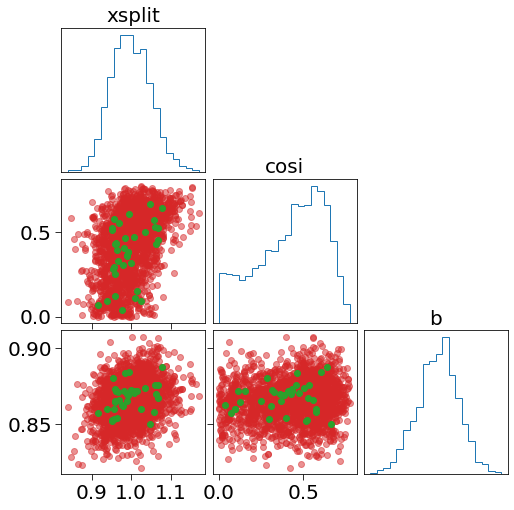

In [126]:
labels=['xsplit','cosi','b']
divergence_corner(trace, labels)

I feel like I'm probably fine on the divergence front here?

Only showing the entry [3] for multi-parameter labels


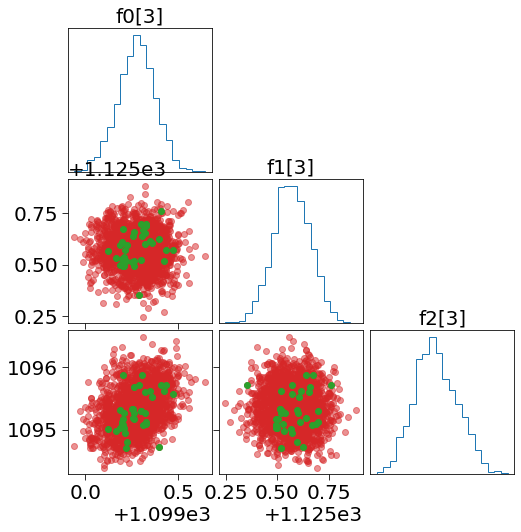

In [128]:
divergence_corner(trace, ['f0', 'f1', 'f2'], entry=3)

Looks like I'm fine on these as well.

Only showing the entry [0] for multi-parameter labels


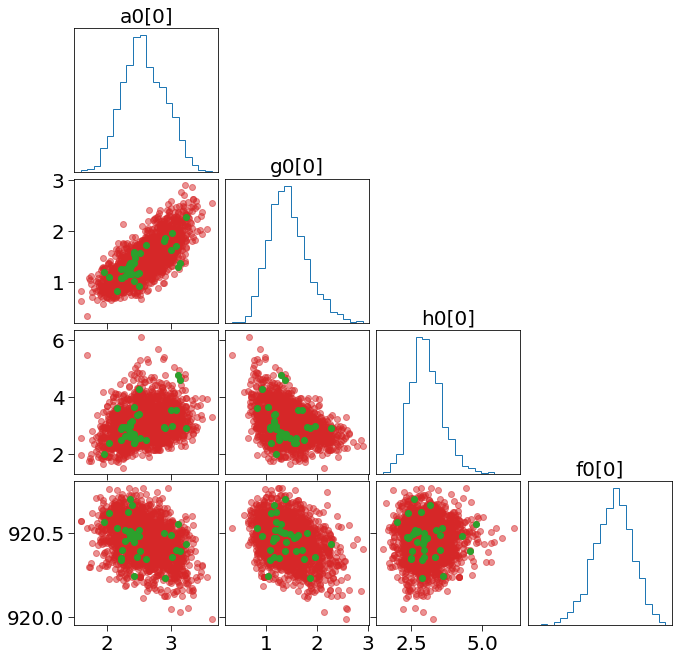

In [129]:
divergence_corner(trace, ['a0','g0','h0','f0'], entry=0)

Looks like I'm all good.